In [1]:
import numpy as np
import pandas as pd
import random 
from scipy import stats
import matplotlib.pyplot as plt
from itertools import islice
import plotly.express as px
import matplotlib.pyplot as plt
from itertools import compress
import math

In [2]:
# parameters
LWH = ['L','W','H']

In [238]:
# helper functions

# chunks a list into a list of lists of specified size
def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())

# repeater n(for plotting bins)
def repeater(x,n,droplast=True):
    if droplast:
        x = x[:-1]
        n = n[:-1]      
    return [ele for i, ele in enumerate(x) for j in range(n[i])]

# create random values 
def randim(dimrange, n, upperlimit=False, dist='uniform'):    
    limit = math.inf  
    if dist=='uniform':
        d = np.random.randint(dimrange[0], dimrange[1], n)    
    if upperlimit:
        d = np.append(d, limit)        
    return d

# add "infinite" bin to catch cases larger than largest bin
def add_infbin(bins, Vflag=False):
    infbin = pd.DataFrame(dict(zip(LWH,[math.inf]*3)), index=[0])
    if Vflag:
        infbin['V'] = math.inf
    return pd.concat([bins, infbin], ignore_index=True)

In [230]:
# user-defined probability functions

# shrink probability function
def shrinkp(u):
    return (1-u)**2

# split probability function
def splitp(c,cmax):
    return min(1,(c/cmax)**2)

# grow probability function
def growthp(c,cmin):
    return min(1,(cmin/c)**2)

# return indexes based on probabilities
def selector(probs):
    return np.where(np.random.random(size=len(probs)) < probs)[0]

In [7]:
# create cases (or bins) with length, width, and height inputs
def create_cases(limits, n, bins_flag=False, vol_flag=True):
    
    # create dimensions dataframe
    cases = pd.DataFrame(columns=['L','W','H'])
    
    # populate dataframe
    for k in limits.keys():
        cases[k] = randim(limits[k], n, bins_flag)

    # sort ascending order
    cases = cases.sort_values(['L','W','H']).reset_index(drop=True)
    
    # calculate volume (cuft)
    if vol_flag:
        cases['V'] = np.round(cases.L * cases.W * cases.H / 12**3, 2)
    
    if bins_flag:
        # max volume for "no bin" bin
        cases.V.values[-1] = math.inf      
       
    return cases

In [231]:
# calculate fitness of bin population
def binPOPfit(cases, nbins, beta = 0):
    
    ncases = len(cases)
    
    ### RETHINK THIS - there should be a battle between binned and utility
    # calc percentage of cases with bins
    # exclude max binID (catches too-big cases)
    idxID = cases.binID < (nbins-1)
    binned = sum(idxID) / ncases
    
    # total bin utilization (excluding extremes)
    if sum(cases.binV[idxID]) != 0:
        util = sum(cases.V[idxID]) / sum(cases.binV[idxID])
    else:
        util = 0
    
    # unique bin count
    uniqueB = len(set(cases.binID))

    # total fitness
    F = binned * util * (1 - beta*uniqueB/nbins)
    
    return binned, util

In [232]:
def mutate(bins,step=1):   
    nbins = len(bins)
    
    # potential sizes of mutations
    mshift = list(range(-step,step+1))
    # calculate mutations
    mutations = list(chunk(random.choices(mshift, k=3*nbins), 3))
    mutations = pd.DataFrame(mutations, columns=['L','W','H'])
    # add mutations to selected rows
    bins = bins.reset_index(drop=True) + mutations
    
    return bins


In [65]:
# print block
def printdetails():
    print('gen', gen)
    #print('cases')
    #print(casePOP)
    print('bins')
    print(binPOP)
    print('binned', binned)
    print('util', util) 
    print(' ')

In [259]:
def shrink(bins):
    
    # shrink probability increases as utility decreases, 
    # zero at 100% utility, one when utility is zero
    # catch bin (nobin) will always shrink (essentially creates new bin)
    probs = shrinkp(bins.util)
    
    # selection of bins to shrink, based on probabilities set above
    shrinkIDs = selector(probs)
    
    # shrink to maximum dimensions across all cases in bin
    shrinks = bins.loc[shrinkIDs,['Lmax','Wmax','Hmax']] 
    shrinks.columns = LWH
    
    # update shrink bins
    bins.update(shrinks)   
    
    return bins

In [268]:
def grow(bins,cmin,step):
    
    # grow probability increases as bin gets closer to minimum case count
    # probability is 100% at minimum case count (and below)
    probs = [growthp(c,cmin) for c in bins.cases]
    
    # selection of bins to grow, based on probabilities set above
    growIDs = selector(probs)
    
    # get new dimensions by adding growth step to maximum dimensions (across all cases in bin)
    grows = bins.loc[growIDs,['Lmax','Wmax','Hmax']] + step
    grows.columns = LWH
    
    # update grow bins
    bins.update(grows) 
    
    return bins

In [260]:
def split(bins,cmax):
    
    # split probability increases as bin gets closer to maximum case count
    # probability is 100% at maximum case count (and above) 
    probs = [splitp(c,cmax) for c in bins.cases]
    
    # select bins to split, based on probabilities set above
    splitIDs = selector(probs)
    
    # get case IDs for "median" case in each bin
    caseIDs = bins.loc[splitIDs, 'caseIDs'].apply(np.median).astype(int)
    
    # calculate cases in (new) smaller bin and remaining in (original) larger bin
    # reset index for small to match new bins; keep index for original
    small = bins.loc[splitIDs, 'cases'].apply(lambda x: math.ceil(x/2)).reset_index(drop=True)
    big = bins.loc[splitIDs, 'cases'].apply(lambda x: math.floor(x/2))
 
    # set new, smaller bin dimensions to "median" case dimensions
    # and add case count
    splits = cases.loc[caseIDs,LWH].reset_index(drop=True)
    splits['cases'] = 0
    splits.update(pd.Series(small, name='cases', index=list(range(len(splitIDs)))))

    # update case count for original bins after split
    bins.update(pd.Series(big, name='cases', index=splitIDs)) 
        
    # add splits to bins
    bins = pd.concat([bins, splits], ignore_index=True).reset_index(drop=True)
    
    return bins

In [262]:
def cleanup(bins):
    # sort bins
    bins = bins.sort_values(LWH)
    
    # drop duplicates
    bins.drop_duplicates(inplace=True, ignore_index=True)
    
    # calculate volume
    bins['V'] = bins.L * bins.W * bins.H / 12**3

    # add catch bin
    bins = add_infbin(bins, Vflag=True)
    
    return bins

In [315]:
randim([0,2],nbins)

array([1, 0, 0, 0, 1, 0])

In [313]:
nbins

6

In [310]:
range(nbins)

[0, 1, 2, 3, 4, 5]

In [308]:
np.random.randint(0, nbins, nbins)

array([4, 1, 4, 1, 4, 1])

In [279]:
def nextgen(bins, cases, cmin, cmax):
    
    # settings
    kill = True
    shrink = True
    grow = True
    split = True
    offspring = False
    mutations = True
    mutaterate = 0.1
    growthstep = 1
    
    nbins = len(bins)
    ncases = len(cases)    
    
    ### 1 - IDENTIFY SURVIVORS: they live  
    # bins survive when they hold minimum case count
    if kill:
        survivors = [c>=cmin for c in bins.cases]
        bins = bins.loc[survivors].reset_index(drop=True)
   
    ### 2 - LOW UTILITY: shrink bin size
    if shrink:
        bins = shrink(bins)
    
    ### 3 - LOW CASE COUNTS: grow bin size
    if grow:
        bins = grow(bins,cmin,growthstep)

    ### 4 - HIGH CASE COUNT: "split" into two bins (create smaller bin)
    if split:
        bins = split(bins,cmax)
    
    
    ### surviving population - dimensions only (drop fit data)
    bins = bins.copy()[LWH] 
    nbins = len(bins)
    
    ### 5 - OFFSPRING
    # combine dimensions of "best" bins to form new bins
    # ("best" bins are parents, new bins are offspring)
    # chose splice location randomly
    if splicing:
        splicedim = randim([0,2],nbins)
        replacements = create_cases(binlimits, zbins, vol_flag=False)
        bins = pd.concat([bins, replacements], ignore_index=True)

    ### 6 - MUTATIONS
    # mutate survivors plus new bins from splicing
    if mutations:
        binIDs = selector([mutaterate]*len(bins))
        if len(binIDs)!=0:
            mutants = mutate(bins.loc[binIDs,:])
            bins.update(mutants)   
    
    ### 7 - CLEANUP
    # prepare bins to be next generation
    bins = cleanup(bins)
    
    return bins

In [280]:
# calculate fitness of each bin relative to bin population fitness
def binFIT(cases, bins, util):
    
    ncases = len(cases)
    nbins = len(bins)

    # total volumes (cases and bins)
    cases['caseID'] = cases.index
    fit = cases.groupby('binID').agg(
        cases = ('binID', 'count'),
        totalV = ('V', 'sum'),
        totalbinV = ('binV', 'sum'),
        caseIDs = ('caseID', list),
        Lmin = ('L', 'min'),
        Wmin = ('W', 'min'),
        Hmin = ('H', 'min'),
        Lmax = ('L', 'max'),
        Wmax = ('W', 'max'),
        Hmax = ('H', 'max')
    )  
    
    # drop last bin ('not' binned bin)
    drop_idx = list(set.intersection(set(fit.index), {nbins+1}))
    fit.drop(index=drop_idx, inplace=True)
    
    # calculate utilization and fitness
    fit['util'] = fit.totalV / fit.totalbinV
    fit['fitratio'] = fit.util / util
    
    # join bins and fit data
    bins = pd.concat([bins, fit], axis=1, join='outer')
    bins.fillna(0, inplace=True)
    bins.cases = bins.cases.astype(int)
      
    return bins

In [281]:
def fit_to_bins(cases, bins):
    
    # initialize
    ncases = len(cases)
    nbins = len(bins)
    binIDs = [0] * ncases
    
    # loop through each case
    for i in range(ncases):
        casei = cases.loc[i,LWH].to_frame().T.reset_index(drop=True)
        
        # join case to bin list
        joined = bins.join(-casei, lsuffix='bin', rsuffix='case').ffill()
        
        # check each case dimension against each bin dimension
        fits = (joined.groupby(joined.columns.str[0], axis=1).sum()[LWH] >= 0)
        fits.iloc[-1] = [True]*3 # until I figure out sum with inf

        # choose first bin that fits
        binIDs[i] = np.min(np.where(fits.product(axis=1)))
        
    cases['binID'] = binIDs
    cases['binV'] = bins.V[cases.binID].reset_index(drop=True)
    
    return cases

In [291]:
# initialization 

## set up dimension ranges for randomly sized cases or bins
caselimits = {'L': [20,30], 'W': [10,20], 'H': [5,10]}
binlimits = {'L': [20,30], 'W': [10,20], 'H': [5,10]}

In [298]:
ncases = 10
nbins = 3
cmax = ncases / nbins * 2
cmin = ncases / nbins / 3

generations = 100
results = pd.DataFrame(columns=['bintocaseratio', 
                                'binned', 
                                'util',
                                'caseminp',
                                'casemedp',
                                'casemaxp'], index=range(generations))
binhistory = []
archive = True
print_flag = True

# create initial population of cases
casePOP = create_cases(caselimits, ncases)
print(casePOP)

# create initial (unique) population of bins
# get unique set of bins
binPOP = create_cases(binlimits, nbins, bins_flag=True)

# generation loop
for gen in range(generations):
            
    nbins = len(binPOP)
    
    # match current population of cases to bins
    casePOP = fit_to_bins(casePOP, binPOP)
        
    # get fitness of current bin population
    binned, util = binPOPfit(casePOP, nbins)
    
    # add fitness to bin population
    binPOP = binFIT(casePOP, binPOP, util)   

    # store results
    results.bintocaseratio[gen] = (nbins - 1)/ncases * 100
    results.binned[gen] = binned * 100
    results.util[gen] = util * 100
    results.caseminp[gen] = np.min(binPOP.cases[binPOP.cases>0]) / ncases * 100
    results.casemedp[gen] = np.median(binPOP.cases) / ncases * 100
    results.casemaxp[gen] = np.max(binPOP.cases) / ncases * 100
    
    # save history
    if archive:
        binhistory.append(binPOP)
        
    if print_flag & (generations<=10):
        printdetails()

    # new generation  
    binPOP = nextgen(binPOP, casePOP, cmin, cmax)
    
    # new case population
    casePOP = create_cases(caselimits, ncases)


    L   W  H     V
0  20  17  9  1.77
1  21  14  5  0.85
2  23  10  9  1.20
3  23  12  5  0.80
4  25  15  5  1.09
5  26  12  6  1.08
6  26  13  9  1.76
7  27  14  6  1.31
8  29  13  5  1.09
9  29  14  5  1.17


In [299]:
gen

99

In [300]:
# melt results for plot    
results_melt = pd.melt(results.reset_index(), id_vars='index', var_name='measure')   

dashmap = dict(zip(['bintocaseratio','binned','util','caseminp','casemedp','casemaxp'],
                   ['dash','solid','solid','dot','dot','dot']))

fig = px.line(results_melt, 
              x='index', y='value', color='measure', line_dash='measure',
              line_dash_map=dashmap)
fig.add_hline(y=100, line_dash='dot')
fig.update_yaxes(range = [0,110])
fig.show()

In [297]:
binG = binhistory[generations-1]
bi = repeater(binG.index,binG.cases)
bl = repeater(binG.L,binG.cases)
bw = repeater(binG.W,binG.cases)
bh = repeater(binG.H,binG.cases)
bh = [-h for h in bh]
catchbin = binG.index.max()

cases = casePOP.sort_values(['binID','L','W','H'])
ci = cases.caseID
cl = cases.L
cw = cases.W
ch = cases.H
ch =[-h for h in ch]
casecolor = ['orange' if bi==catchbin else 'cornflowerblue' for bi in cases.binID]

xticks=[]
w = bw + [w for (w,b) in zip(cases.W,cases.binID) if b==catchbin]
for n, c in enumerate(w):
    xticks.append(sum(w[:n]) + w[n]/2)


KeyError: 'binID'

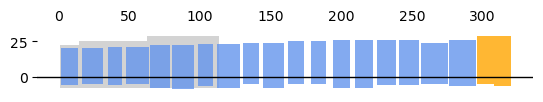

In [290]:
fig, ax = plt.subplots()

ax.bar(xticks[:len(bi)], height = bl, width = bw,
           alpha = 1, color='lightgray', linewidth=0)
ax.bar(xticks, height = cl, width = cw,
           alpha = 0.8, color=casecolor, linewidth=0)
ax.bar(xticks[:len(bi)], height = bh, width = bw,
           alpha = 1, color='lightgray', linewidth=0)
ax.bar(xticks, height = ch, width = cw,
           alpha = 0.8, color=casecolor, linewidth=0)
#ax.xticks(xticks,ci)
#ax.xticks(xticks,bi,minor=True)
#ax.xaxis.set_minor_locator(FixedLocator(xticks))
ax.xaxis.set_minor_formatter('{x:.0f}')
ax.tick_params(which='major', top=False, labeltop=True, bottom=False, labelbottom=False)
ax.tick_params(which='minor', top=False, labeltop=False, bottom=False, labelbottom=True)
ax.axis('scaled')
fig.gca().set_frame_on(False)
ax.axhline(y=0, color='black', linewidth=1)


In [ ]:
#add bin ID to bottom, only show first one (blank out subsequent)